In [13]:
# %matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng(729)

%load_ext autoreload
%autoreload 2

from brain import k_cap, idx_to_vec, FFArea, RecurrentArea, RandomChoiceArea, ScaffoldNetwork, FSMNetwork, PFANetwork, AttentionArea

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
rng = np.random.default_rng(729)

n_symbol_neurons = 1000
n_state_neurons = 500
n_arc_neurons = 5000
cap_size = 70
density = 0.2
plasticity = 1e-1

n_symbols = 10 + 1  # digits 0-9 plus blank symbol
n_states = 3 + 2    # mod-3 states plus accept/reject

transition_list = []
for mod in range(3):
    for digit in range(10):
        transition_list.append((mod, digit, (mod + digit) % 3))
transition_list.extend([(0, 10, 3), (1, 10, 4), (2, 10, 4)])

def build_fsm_network():
    net = FSMNetwork(n_symbol_neurons, n_state_neurons, n_arc_neurons, cap_size, density, plasticity)
    symbols = np.arange(n_symbols * cap_size).reshape(n_symbols, cap_size)
    states = np.arange(n_states * cap_size).reshape(n_states, cap_size)
    return net, symbols, states

def train_fsm_network(net, n_presentations, symbols, states):
    for _ in range(n_presentations):
        for mod, symbol_idx, new_mod in transition_list:
            net.train(symbols[symbol_idx], states[mod], states[new_mod])
    return net

In [15]:
presentation_counts = np.arange(1, 50, dtype=int)
lengths = np.arange(0, 50, dtype=int)
n_trials_per_len = 3

eval_rng = np.random.default_rng(2025)
eval_digits = np.empty((lengths.size, n_trials_per_len), dtype=object)
for i, L in enumerate(lengths):
    for t in range(n_trials_per_len):
        if L == 0:
            eval_digits[i, t] = np.array([], dtype=int)
        else:
            eval_digits[i, t] = eval_rng.integers(0, 10, size=L)

In [16]:
per_len_results = np.zeros((presentation_counts.size, lengths.size, n_trials_per_len), dtype=np.float32)
per_len_acc = np.zeros((presentation_counts.size, lengths.size), dtype=np.float32)
overall_acc = np.zeros(presentation_counts.size, dtype=np.float32)

for p_idx, n_presentations in enumerate(presentation_counts):
    fsm_net, dfa_symbols, dfa_states = build_fsm_network()
    train_fsm_network(fsm_net, int(n_presentations), dfa_symbols, dfa_states)
    state_basis = idx_to_vec(dfa_states, n_state_neurons)
    for len_idx, L in enumerate(lengths):
        for trial_idx in range(n_trials_per_len):
            digits = eval_digits[len_idx, trial_idx]
            gt_accept = (digits.sum() % 3 == 0)
            seq = list(digits) + [10]
            fsm_net.inhibit()
            fsm_net.state_area.fire(dfa_states[0], update=False)
            for symbol_idx in seq:
                fsm_net.forward(dfa_symbols[symbol_idx], update=False)
            final_dense = fsm_net.read(dense=True)
            final_overlap = final_dense @ state_basis.T / cap_size
            pred_state = int(np.argmax(final_overlap))
            pred_accept = (pred_state == 3)
            per_len_results[p_idx, len_idx, trial_idx] = float(pred_accept == gt_accept)
        per_len_acc[p_idx, len_idx] = per_len_results[p_idx, len_idx].mean()
    overall_acc[p_idx] = per_len_acc[p_idx].mean()
    if (p_idx + 1) % 50 == 0 or n_presentations == presentation_counts[-1]:
        print(f'Completed {p_idx + 1} / {presentation_counts.size} presentation counts')

Completed 49 / 49 presentation counts


Final overall accuracy (n_presentations=49): 1.000
Overall accuracy checkpoints:
    1: 0.627
    5: 0.667
   10: 0.680
   20: 1.000


IndexError: index 49 is out of bounds for axis 0 with size 49

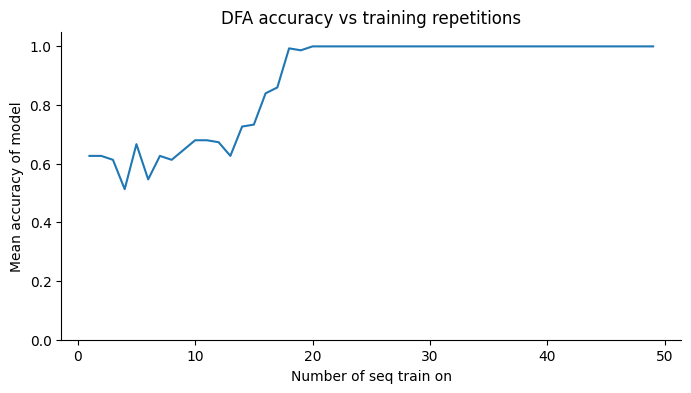

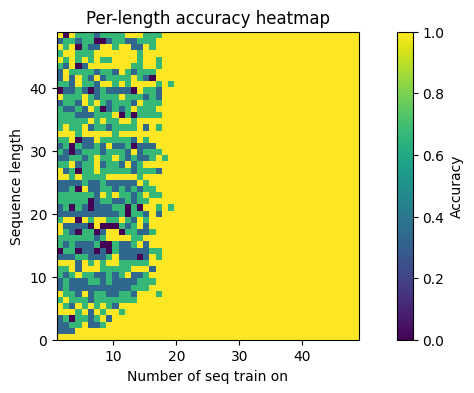

In [19]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(presentation_counts, overall_acc)
ax.set_xlabel('Number of seq train on')
ax.set_ylabel('Mean accuracy of model')
ax.set_ylim(0, 1.05)
ax.set_title('DFA accuracy vs training repetitions')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig2, ax2 = plt.subplots(figsize=(10, 4))
heatmap = ax2.imshow(
    per_len_acc.T,
    origin='lower',
    extent=[presentation_counts[0], presentation_counts[-1], lengths[0], lengths[-1]],
    vmin=0,
    vmax=1,
)
ax2.set_xlabel('Number of seq train on')
ax2.set_ylabel('Sequence length')
ax2.set_title('Per-length accuracy heatmap')
fig2.colorbar(heatmap, ax=ax2, label='Accuracy')

print(f'Final overall accuracy (n_presentations={presentation_counts[-1]}): {overall_acc[-1]:.3f}')
print('Overall accuracy checkpoints:')
for checkpoint in [1, 5, 10, 20, 50, 100, 200, 300, 400, 500]:
    idx = checkpoint - 1
    print(f'  {checkpoint:3d}: {overall_acc[idx]:.3f}')